In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

df_manual = pd.read_parquet(
    '../data/manual_predictions.parquet',
    columns=['id','rating']
    ).rename(
        columns={'rating':'rating_manual'}
    )
df_llm = pd.read_parquet(
    '../data/llm_predictions.parquet',
    columns=['id','model','rating','processing_time']
    ).rename(
        columns={'rating':'rating_llm'}
    )
df_comments = pd.read_parquet(
    '../data/comments.parquet',
    columns=['id','rating','comment_length_group','pros_length_proportion_group']
    ).rename(
        columns={'rating':'rating_real'}
    )

print(f"Comments manually predicted: {len(df_manual)}")
print(f"LLM predictions: {len(df_llm)}")
print(f"LLM models: {set(df_llm['model'])}")

Comments manually predicted: 402
LLM predictions: 30432
LLM models: {'stablelm2:1.6b', 'qwen2.5:0.5b', 'qwen2.5:1.5b', 'llama3.1:8b', 'deepseek-r1:8b', 'llama3.2:3b', 'stablelm2:12b', 'qwen2.5:3b', 'deepseek-r1:1.5b', 'llama2:7b'}


In [2]:
df = df_manual\
    .merge(df_llm, on='id', how='left')\
    .merge(df_comments, on='id', how='inner')

for type in ['manual','llm']:
    df[f'is_inconsistent_{type}'] = (
        (df[f'rating_{type}'] - df['rating_real']).abs() > 1
        ).astype(int)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3912 entries, 0 to 3911
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            3912 non-null   object 
 1   rating_manual                 3912 non-null   int64  
 2   model                         3900 non-null   object 
 3   rating_llm                    3900 non-null   float64
 4   processing_time               3900 non-null   float64
 5   rating_real                   3912 non-null   int64  
 6   comment_length_group          3912 non-null   int64  
 7   pros_length_proportion_group  3912 non-null   int64  
 8   is_inconsistent_manual        3912 non-null   int64  
 9   is_inconsistent_llm           3912 non-null   int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 305.8+ KB


In [3]:
y_true = df['is_inconsistent_manual']
y_pred = df['is_inconsistent_llm']

cm = confusion_matrix(y_true, y_pred)
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print("Matriz de Confusão:\n", cm)
print(f"Acurácia: {accuracy:.3f}  Precision: {precision:.3f}")
print(f"Recall:   {recall:.3f}  F1‐score:  {f1:.3f}")

Matriz de Confusão:
 [[2644  514]
 [ 323  431]]
Acurácia: 0.786  Precision: 0.456
Recall:   0.572  F1‐score:  0.507


In [4]:
df = df.dropna(subset=['model'])

metrics = []
for model, group in df.groupby('model'):
    y_true = group['is_inconsistent_manual']
    y_pred = group['is_inconsistent_llm']

    metrics.append({
        'model': model,
        'accuracy':  accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall':    recall_score(y_true, y_pred, zero_division=0),
        'f1_score':  f1_score(y_true, y_pred, zero_division=0)
    })

metrics_df = pd.DataFrame(metrics).sort_values('f1_score', ascending=False)

display(metrics_df)


,model,accuracy,precision,recall,f1_score
9,stablelm2:12b,0.869231,0.681818,0.600000,0.638298
2,llama2:7b,0.820513,0.523364,0.746667,0.615385
5,qwen2.5:0.5b,0.728205,0.407186,0.906667,0.561983
1,deepseek-r1:8b,0.774359,0.442478,0.666667,0.531915
0,deepseek-r1:1.5b,0.753846,0.416000,0.693333,0.520000
3,llama3.1:8b,0.851282,0.757576,0.333333,0.462963
4,llama3.2:3b,0.833333,0.608696,0.373333,0.462810
6,qwen2.5:1.5b,0.705128,0.348485,0.613333,0.444444
8,stablelm2:1.6b,0.771795,0.405405,0.400000,0.402685
7,qwen2.5:3b,0.756410,0.378049,0.413333,0.394904


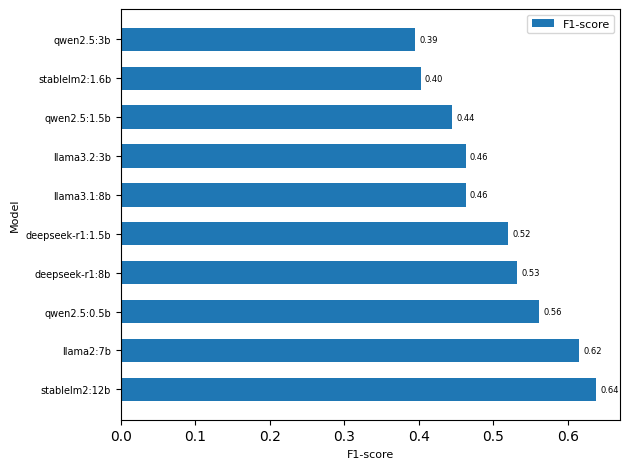

In [5]:
import numpy as np
import matplotlib.pyplot as plt

models = metrics_df['model'].tolist()
y = np.arange(len(models))
bar_height = 0.6

fig, ax = plt.subplots()
bars_f1 = ax.barh(y, metrics_df['f1_score'], height=bar_height, label='F1-score')

ax.bar_label(bars_f1, fmt='%.2f', padding=3, fontsize=6)

ax.set_yticks(y)
ax.set_yticklabels(models, fontsize=7)
ax.set_xlabel('F1-score', fontsize=8)
ax.set_ylabel('Model', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


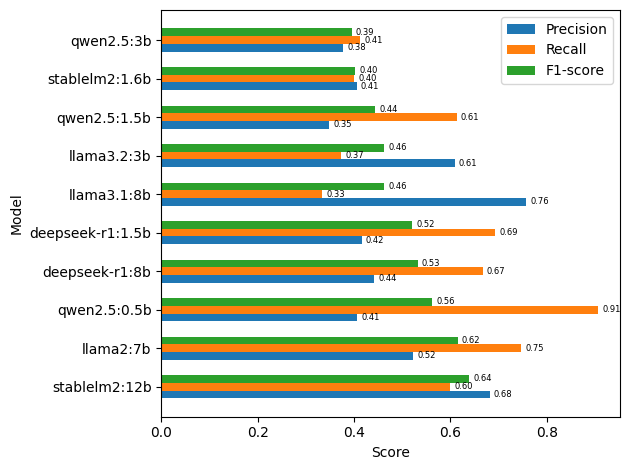

In [6]:
models = metrics_df['model'].tolist()
y = np.arange(len(models))
bar_height = 0.2

fig, ax = plt.subplots()

bars_prec = ax.barh(y - bar_height, metrics_df['precision'],  height=bar_height, label='Precision')
bars_rec  = ax.barh(y,            metrics_df['recall'],     height=bar_height, label='Recall')
bars_f1   = ax.barh(y + bar_height, metrics_df['f1_score'],   height=bar_height, label='F1-score')

ax.bar_label(bars_prec, fmt='%.2f', padding=3, fontsize=6)
ax.bar_label(bars_rec,  fmt='%.2f', padding=3, fontsize=6)
ax.bar_label(bars_f1,   fmt='%.2f', padding=3, fontsize=6)

ax.set_yticks(y)
ax.set_yticklabels(models)
ax.set_xlabel('Score')
ax.set_ylabel('Model')
ax.legend()

plt.tight_layout()
plt.show()


# A fazer
- Gerar diferentes combinações de grupos de 3 e 5 modelos
- Calcular previsão dos grupos com base em Votação Majoritária e Votação Ponderada (base f1)
- Comparar desempenho entre diferentes notas e tamanho de comentários
- Extrair número de parâmetros de cada modelo
- Comparar desempenho entre diferentes tamanhos de modelos e tempo de processamento

In [12]:
groups = {
    "top3": [
        'stablelm2:12b',
        'llama2:7b',
        'qwen2.5:0.5b'
    ],
    "top5": [
        'stablelm2:12b',
        'llama2:7b',
        'qwen2.5:0.5b',
        'deepseek-r1:8b',
        'deepseek-r1:1.5b'
    ],
    "small3": [
        'qwen2.5:0.5b',
        'deepseek-r1:1.5b',
        'qwen2.5:1.5b'
    ],
    "big3": [
        'llama3.1:8b',
        'stablelm2:12b',
        'llama2:13b'
    ]
}

results = []
for group_name, modelos in groups.items():
    sub = df[df['model'].isin(modelos)].drop_duplicates(['id', 'model'])
    wide = (
        sub
        .pivot(index='id', columns='model', values='is_inconsistent_llm')
        .fillna(0)
        .astype(int)
    )
    
    threshold = len(modelos) / 2
    wide = wide.assign(
        is_inconsistent_llm=(wide.sum(axis=1) > threshold).astype(int)
    ).reset_index()[['id', 'is_inconsistent_llm']]

    wide['group'] = group_name+'_majority'
    results.append(wide)


manual = df[['id', 'is_inconsistent_manual']].drop_duplicates('id')
result = pd.concat(results, ignore_index=True)
result = (
    result
    .merge(manual, on='id', how='left')
    .loc[:, ['group', 'is_inconsistent_llm', 'is_inconsistent_manual']]
)

display(result[result['group']=='top5_majority'].head())


,group,is_inconsistent_llm,is_inconsistent_manual
390,top5_majority,0,0
391,top5_majority,0,0
392,top5_majority,0,0
393,top5_majority,0,0
394,top5_majority,0,0


In [15]:
metrics = []
for model, group in result.groupby('group'):
    y_true = group['is_inconsistent_manual']
    y_pred = group['is_inconsistent_llm']

    metrics.append({
        'model': model,
        'accuracy':  accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall':    recall_score(y_true, y_pred, zero_division=0),
        'f1_score':  f1_score(y_true, y_pred, zero_division=0)
    })

metrics_df = pd.DataFrame(metrics).sort_values('f1_score', ascending=False)

display(metrics_df)

,model,accuracy,precision,recall,f1_score
3,top5_majority,0.866667,0.613861,0.826667,0.704545
2,top3_majority,0.838462,0.562500,0.720000,0.631579
1,small3_majority,0.789744,0.475177,0.893333,0.620370
0,big3_majority,0.851282,0.947368,0.240000,0.382979


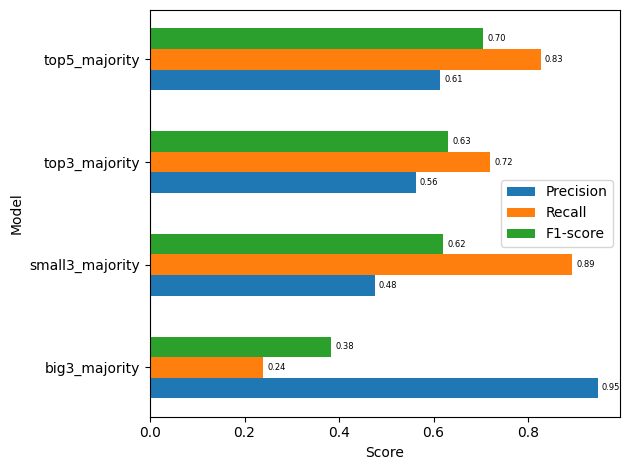

In [17]:
metrics_df = metrics_df.sort_values('f1_score', ascending=True)
models = metrics_df['model'].tolist()
y = np.arange(len(models))
bar_height = 0.2

fig, ax = plt.subplots()

bars_prec = ax.barh(y - bar_height, metrics_df['precision'],  height=bar_height, label='Precision')
bars_rec  = ax.barh(y,            metrics_df['recall'],     height=bar_height, label='Recall')
bars_f1   = ax.barh(y + bar_height, metrics_df['f1_score'],   height=bar_height, label='F1-score')

ax.bar_label(bars_prec, fmt='%.2f', padding=3, fontsize=6)
ax.bar_label(bars_rec,  fmt='%.2f', padding=3, fontsize=6)
ax.bar_label(bars_f1,   fmt='%.2f', padding=3, fontsize=6)

ax.set_yticks(y)
ax.set_yticklabels(models)
ax.set_xlabel('Score')
ax.set_ylabel('Model')
ax.legend()

plt.tight_layout()
plt.show()
